In [1]:
#prepare libs
import sys
import pystan
import matplotlib.pyplot as plt
import matplotlib as mpl
import stan_utility
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

Aviation accidents 1976-1985

extra source:
Aviation Safety, Human Factors - System Engineering - Flight Operations - Economics - Strategies - Management
 // author Hans M. Soekkha

In [14]:
#prepare data
accidents = [24,25,31,31,22,21,26,20,16,22]
deaths = [734,516,754,877,814,362,764,809,223,1066]
death_rate = [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15] 

aviation_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':accidents,  
'Passenger deaths':deaths,
'Death rate':death_rate}).set_index('Year')
aviation_data['miles flown [100 mln miles]'] = np.round(aviation_data['Passenger deaths']/aviation_data['Death rate'])
                            

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [34]:
acc=[]
data_ = []
for i in aviation_data['Passenger deaths']:  
    data_.append(-(1.+acc.count(k)))
    acc.append(k)
data_=np.array(dta_cnt)

aviation_data

,Fatal accidents,Passenger deaths,Death rate,miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


exercise 1

The rate is constant for all years and not depending on anything


We need to create prior model. Our goal is distribution with a probability less than 1% to accept 20 000 deaths.
We need to find the  𝜆  parameter which meet the requirements: 𝜆+3√𝜆≈20000

In [21]:
root_lambda = np.polynomial.polynomial.polyroots([-20000.,3.,1.])
lambda_ = np.round(root_lambda[root_lambda>0]**2)
print(lambda_)

[19580.]


Parameter 𝜆 must be in range of ∈(0,19580)

In [22]:
with open('da4_stan_files\\prior_model.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess;
  vector[1] theta;
}

transformed data {
  vector[1] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
}

generated quantities {
  real sigma = exp(y[1]);
}


In [23]:
prior_model =stan_utility.compile_model('da4_stan_files\\prior_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7503279f6876cbee407a2d382e22bbd NOW.


In [26]:
data = dict(y_guess=np.array([np.log(10000)]),theta=np.array(lambda_))
tuned = prior_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned.extract()['sigma'][0])
print(sigma) 

7601.0


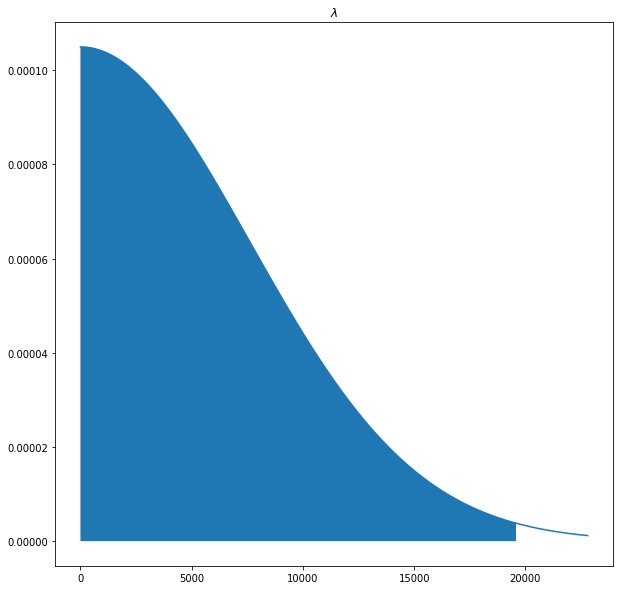

In [28]:
fig, ax2 = plt.subplots(1, 1,figsize=(10, 10))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lambda_[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma))
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_title('$\lambda$')
plt.show()

In [30]:
#Prior predictive check
# Based on the parameters (calculated sigma and lambda), we can find appropriate half-normal distribution and poisson distribution

with open('da4_stan_files\\predictive_prior1.stan', 'r') as file:
    print(file.read())


data {
  int M;
}
generated quantities {
  real lambda=fabs(normal_rng(0,7601));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [31]:
predicitve_prior_model =stan_utility.compile_model('da4_stan_files\\predictive_prior1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a4a8071bb9ae37b62dbb3a4aee74223 NOW.


In [33]:
tuned =predicitve_prior_model.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=1000,
                            warmup=0,
                            chains=1, 
                            refresh=1000,
                            seed=1052020)

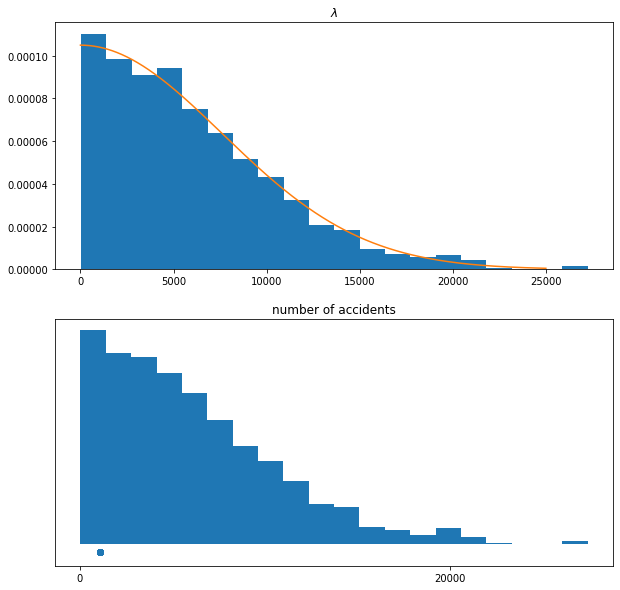

In [38]:
parameters=tuned.extract()
lambda1=parameters['lambda']
y_sim=parameters['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(10, 10))
ax1=axes[0]
ax1.hist(lambda1, bins=20, density=True)
x=np.linspace(0,25000,2000)
ax1.set_title('$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma))
arr_y_loc = 2*stats.norm.pdf(10000,0,sigma)

ax2=axes[1]
ax2.hist(y_sim.flatten(), density=True,bins=20,zorder=1)
ax2.scatter(acc,0.000004*data_)
ax2.set_xticks([0,20000])
ax2.set_yticks([])

ax2.set_title('number of accidents')
plt.show()

Posterior predictive
Try to predict number of deaths in 1986

In [91]:
with open('da4_stan_files\\posterior_predictive1.stan', 'r') as file:
    print(file.read())

data {
  int M;
  int y[M];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,7601);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [92]:
posterior_predictive_model =stan_utility.compile_model('da4_stan_files\\posterior_predictive1.stan')

Using cached StanModel


In [93]:
data = dict(M = len(aviation_data),
            y = aviation_data['Passenger deaths'])
tuned = posterior_predictive_model.sampling(data=data, seed=1052020)

parameters= tuned.extract()
lambda_=parameters['lambda']
y_sim=parameters['y_sim']

mean_lambda = np.mean(lambda_)
cinf_lambda = az.hpd(lambda_,0.89)

hpd_width=cinf_lambda[1]-cinf_lambda[0]

print('mean lambda : {:4.5f}'.format(mean_lambda))
print('89% confidence interval: [',*['{:4.5f}'.format(k) for k in cinf_lambda],']')

mean lambda : 691.70327
89% confidence interval: [ 675.19008 706.66290 ]


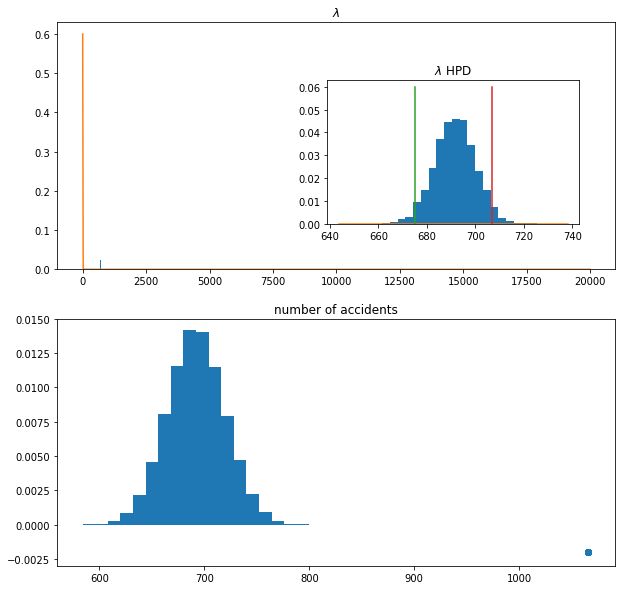

In [94]:
fig, axes = plt.subplots(2, 1,figsize=(10, 10))
ax1=axes[0]
ax1.hist(lambda_, bins=20, density=True)
x=np.linspace(0,20000,1000)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma))
arr_y_loc = 2*stats.norm.pdf(5000,0,sigma)
ax1.set_title('$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lambda[0]-hpd_width, cinf_lambda[1]+hpd_width, 200)
ax_sm.hist(lam,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma))
ax_sm.plot([cinf_lambda[0],cinf_lambda[0]],[0,0.06])
ax_sm.plot([cinf_lambda[1],cinf_lambda[1]],[0,0.06])


ax_sm.set_title('$\lambda$ HPD')

ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(acc,0.002*data_,)

ax2.set_title('number of accidents')
plt.show()

In [95]:
median_y_sim = np.median(y_sim.flatten())
print('median of predicted accidents: ',median_y_sim) # 564 is real world value

median of predicted accidents:  692.0


exercise 2

Unlike last time, now we gonna consider number of miles traveled. 
We need to meet these requierment: 𝜃⋅𝑛+3√(𝜃⋅𝑛) ≈20000

In [54]:
flown_miles_mean =np.mean(aviation_data['miles flown [100 mln miles]'])
root_theta=np.polynomial.polynomial.polyroots([-20000/flown_miles_mean,3./np.sqrt(flown_miles_mean),1.])
theta_ub=(root_theta[root_lambda>0]**2)
print('theta upper bound: ','{:4.5}'.format(theta_ub[0]))

theta upper bound:  3.4256


In [55]:
data= dict (y_guess=np.array([np.log(1)]),theta=np.array(theta_ub))
tuned = prior_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned.extract()['sigma'][0])
print('sigma =','{:4.5}'.format(sigma))

sigma = 1.3299


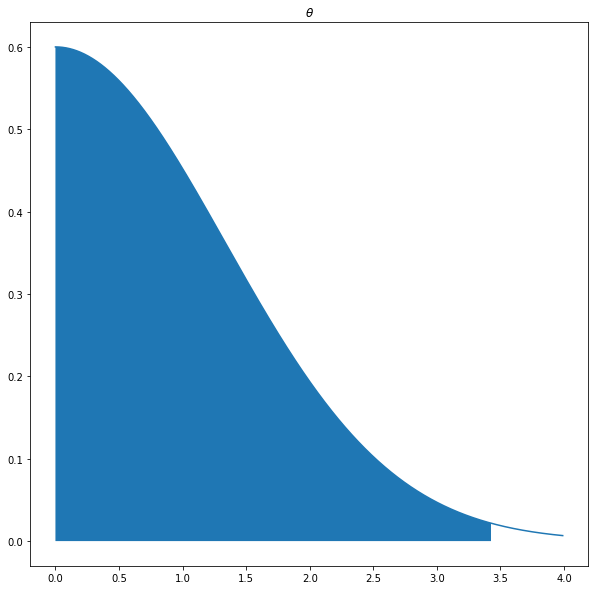

In [57]:
fig, ax2 = plt.subplots(1, 1,figsize=(10, 10))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma))
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_title(r'$\theta$')
plt.show()

In [ ]:
#Prior predictive check


In [58]:
with open('da4_stan_files\\predictive_prior2.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}

generated quantities {
  real theta=fabs(normal_rng(0,1.33));
  int y_sim[M];
  for (k in 1:M)
  {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}


In [59]:
predictive_prior2 = stan_utility.compile_model('da4_stan_files\\predictive_prior2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36207bbe10b976924bbef9a81c58602c NOW.


In [61]:
data2 = dict(M=len(aviation_data),miles=aviation_data['miles flown [100 mln miles]'].to_numpy())
tuned = predictive_prior2.sampling(data=data2,
                            algorithm="Fixed_param", 
                            iter = 1000, 
                            warmup=0, 
                            chains=1, 
                            refresh=1000,
                            seed=1052020)

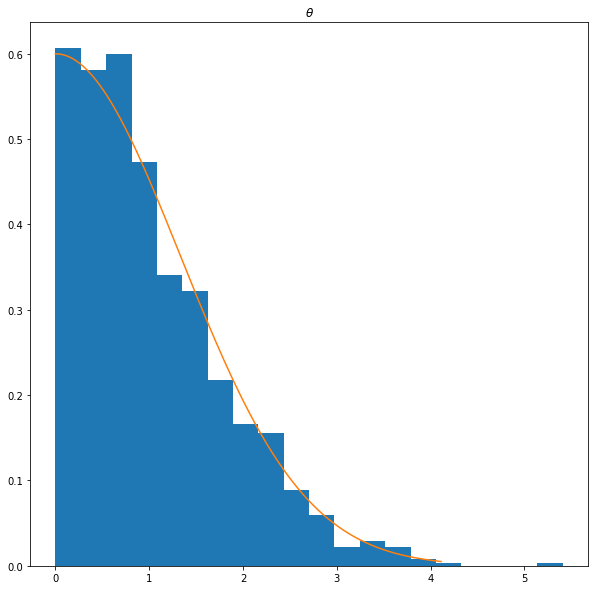

In [62]:
parameters=tuned.extract()
theta=parameters['theta']

fig, axes = plt.subplots(1, 1,figsize=(10, 10))
ax1=axes
ax1.hist(theta,bins=20, density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_title(r'$\theta$')

ax1.plot(x,2*stats.norm.pdf(x,0,sigma))
plt.show()

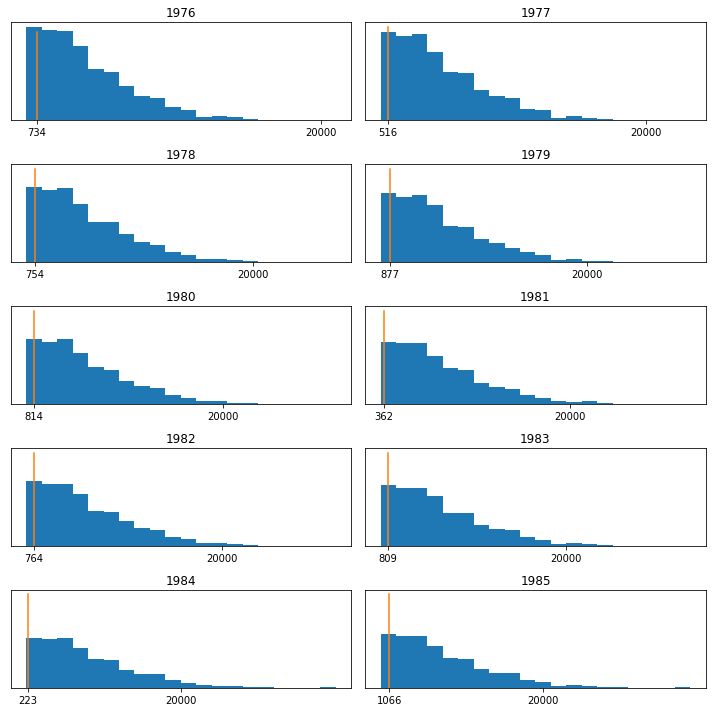

In [67]:
y_sim=parameters['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes_flat=axes.flatten()

for i in range(len(axes_flat)):
    ax = axes_flat[i]
    ax.hist(y_sim[:,i],bins=20, density=True)
    ax.set_title(aviation_data.index[i])
    p =aviation_data['Passenger deaths'].iloc[i]
    ax.plot([p,p],[0,0.00015])
    ax.set_yticks([])
    ax.set_xticks([p,20000])

fig.tight_layout()

plt.show()

In [68]:
#Posterior predictive
with open('da4_stan_files\\posterior_predictive2.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,1.33);
  for (k in 1:M) 
  {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M)
  {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}


In [69]:
posterior_model2 =stan_utility.compile_model('da4_stan_files\\posterior_predictive2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08cad3a8a031d4d5feda1517dccdfda0 NOW.


In [75]:
data3 = dict(M = len(aviation_data), miles = aviation_data['miles flown [100 mln miles]'], y = aviation_data['Passenger deaths'])
tuned = posterior_model2.sampling(data=data3, seed=1052020)

parameters3 = tuned.extract()
theta=parameters3['theta']
y_sim=parameters3['y_sim']
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

print('mean of theta: {:5.5f}'.format(mean_theta))
print('89% of confidence interval: [',*['{:5.5f}'.format(k) for k in cinf_theta],']')

mean of theta: 0.12108
89% of confidence interval: [ 0.11846 0.12384 ]


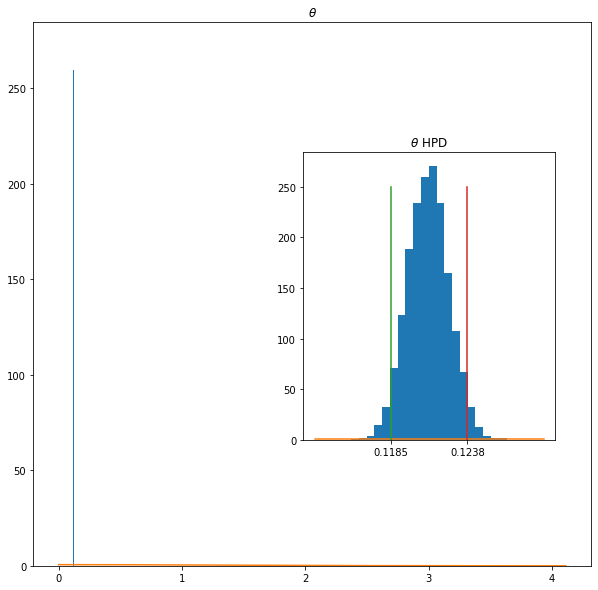

In [79]:
fig, axes = plt.subplots(1, 1,figsize=(10, 10))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma))

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20, density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,250])
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,250])
ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_title(r'$\theta$ HPD')

plt.show()

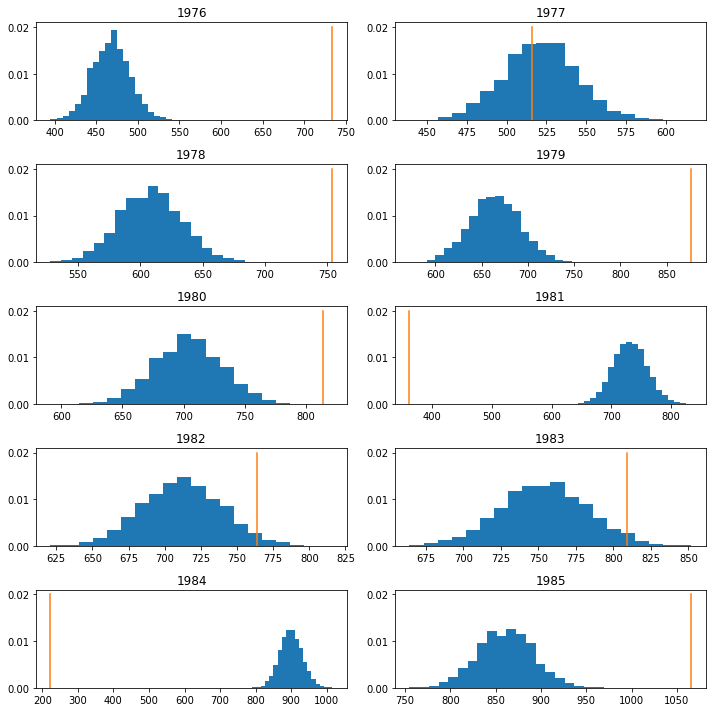

In [81]:
y_sim=parameters3['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes_flat=axes.flatten()
for i in range(len(axes_flat)):
    ax = axes_flat[i]
    ax.hist(y_sim[:,i],bins=20, density=True)
    ax.set_title(aviation_data.index[i])
    p=aviation_data['Passenger deaths'].iloc[i]
    ax.plot([p,p],[0,0.02])
fig.tight_layout()

plt.show()

In [82]:
#prediction model
# 1986 22 fatal accidents, 546 passenger deaths, death rate of 0.06
flown_miles_1986 = 546/0.06
print(flown_miles_1986)

9100.0


In [84]:
with open('da4_stan_files\\prediction_1986.stan', 'r') as file:
    print(file.read())

prediction_1986_model =stan_utility.compile_model('da4_stan_files\\prediction_1986.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a02be13b5d02856a972723bda4176e54 NOW.


data 
{
  int M;
  vector[M] miles;
  int y[M];
}
parameters 
{
  real<lower=0>theta;
}
model 
{
  theta ~ normal(0,1.33);
  for (k in 1:M) 
  {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities 
{
  int y_1986 = poisson_rng(9100*theta);
}


In [89]:
data = dict(M = len(aviation_data),miles = aviation_data['miles flown [100 mln miles]'],y = aviation_data['Passenger deaths'])
tuned  = prediction_1986_model.sampling(data=data, 
                                        seed=1052020)

prediction_data_1986 = tuned.extract()['y_1986']
median_1986 = np.median(prediction_data_1986)
print('median of predicted accidents: ',median_1986)

median of predicted accidents:  1101.0


Unfortunately , accuracy of our prediction model is not so good.